<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[11:03:36] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


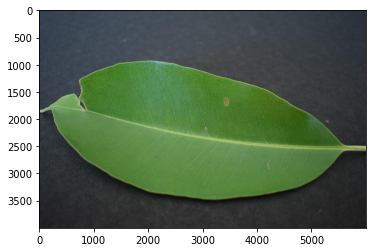

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

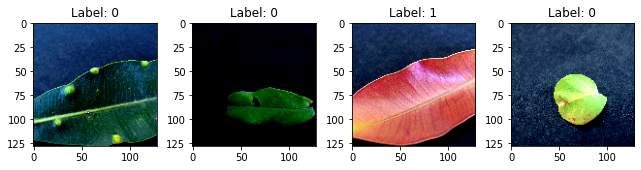

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[11:03:43] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[11:03:45] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.255860764059834 samples/sec                   batch loss = 0.5308266878128052 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2648325662034485 samples/sec                   batch loss = 0.688257098197937 | accuracy = 0.55


Epoch[1] Batch[15] Speed: 1.269617329232349 samples/sec                   batch loss = 0.27853816747665405 | accuracy = 0.6333333333333333


Epoch[1] Batch[20] Speed: 1.2665976742072182 samples/sec                   batch loss = 0.9889172315597534 | accuracy = 0.6125


Epoch[1] Batch[25] Speed: 1.2676439723009343 samples/sec                   batch loss = 1.0091063976287842 | accuracy = 0.59


Epoch[1] Batch[30] Speed: 1.2672513003189048 samples/sec                   batch loss = 0.9036332964897156 | accuracy = 0.6083333333333333


Epoch[1] Batch[35] Speed: 1.270469155038708 samples/sec                   batch loss = 0.7102285623550415 | accuracy = 0.6071428571428571


Epoch[1] Batch[40] Speed: 1.2709445973164226 samples/sec                   batch loss = 0.3073410987854004 | accuracy = 0.60625


Epoch[1] Batch[45] Speed: 1.2733613681236753 samples/sec                   batch loss = 0.5590332746505737 | accuracy = 0.5944444444444444


Epoch[1] Batch[50] Speed: 1.262656107464296 samples/sec                   batch loss = 0.4713914096355438 | accuracy = 0.61


Epoch[1] Batch[55] Speed: 1.2675967545347149 samples/sec                   batch loss = 1.293591856956482 | accuracy = 0.6227272727272727


Epoch[1] Batch[60] Speed: 1.2722971238507708 samples/sec                   batch loss = 0.8753858804702759 | accuracy = 0.6125


Epoch[1] Batch[65] Speed: 1.2699636902700098 samples/sec                   batch loss = 0.44270849227905273 | accuracy = 0.6230769230769231


Epoch[1] Batch[70] Speed: 1.269418574130722 samples/sec                   batch loss = 0.6641610264778137 | accuracy = 0.6178571428571429


Epoch[1] Batch[75] Speed: 1.2699884925096852 samples/sec                   batch loss = 0.7697069644927979 | accuracy = 0.6266666666666667


Epoch[1] Batch[80] Speed: 1.263236898782423 samples/sec                   batch loss = 0.5052119493484497 | accuracy = 0.61875


Epoch[1] Batch[85] Speed: 1.2706660258256117 samples/sec                   batch loss = 0.7534738779067993 | accuracy = 0.6264705882352941


Epoch[1] Batch[90] Speed: 1.2635713170518474 samples/sec                   batch loss = 0.6157681941986084 | accuracy = 0.6361111111111111


Epoch[1] Batch[95] Speed: 1.2712002705272105 samples/sec                   batch loss = 0.3593955636024475 | accuracy = 0.65


Epoch[1] Batch[100] Speed: 1.275176352027141 samples/sec                   batch loss = 1.149936556816101 | accuracy = 0.6425


Epoch[1] Batch[105] Speed: 1.266749731318419 samples/sec                   batch loss = 0.440976619720459 | accuracy = 0.6452380952380953


Epoch[1] Batch[110] Speed: 1.2710779582676317 samples/sec                   batch loss = 0.4206249713897705 | accuracy = 0.6545454545454545


Epoch[1] Batch[115] Speed: 1.2717780565507553 samples/sec                   batch loss = 0.9530589580535889 | accuracy = 0.6521739130434783


Epoch[1] Batch[120] Speed: 1.2683624417140642 samples/sec                   batch loss = 0.19219960272312164 | accuracy = 0.6583333333333333


Epoch[1] Batch[125] Speed: 1.275241583605121 samples/sec                   batch loss = 0.39956608414649963 | accuracy = 0.664


Epoch[1] Batch[130] Speed: 1.2691737941566863 samples/sec                   batch loss = 0.48018720746040344 | accuracy = 0.6692307692307692


Epoch[1] Batch[135] Speed: 1.2690582070935332 samples/sec                   batch loss = 0.5844191312789917 | accuracy = 0.6703703703703704


Epoch[1] Batch[140] Speed: 1.2663687011007536 samples/sec                   batch loss = 0.25836169719696045 | accuracy = 0.6696428571428571


Epoch[1] Batch[145] Speed: 1.2675393892030182 samples/sec                   batch loss = 0.1812790185213089 | accuracy = 0.6655172413793103


Epoch[1] Batch[150] Speed: 1.2669819039977344 samples/sec                   batch loss = 0.5938469767570496 | accuracy = 0.6716666666666666


Epoch[1] Batch[155] Speed: 1.2709772368687893 samples/sec                   batch loss = 1.0404670238494873 | accuracy = 0.6725806451612903


Epoch[1] Batch[160] Speed: 1.2670211339908386 samples/sec                   batch loss = 0.39185184240341187 | accuracy = 0.6734375


Epoch[1] Batch[165] Speed: 1.2696138704191722 samples/sec                   batch loss = 0.19060328602790833 | accuracy = 0.6757575757575758


Epoch[1] Batch[170] Speed: 1.2676457921229716 samples/sec                   batch loss = 1.0267435312271118 | accuracy = 0.675


Epoch[1] Batch[175] Speed: 1.2700719428163847 samples/sec                   batch loss = 0.37522244453430176 | accuracy = 0.6785714285714286


Epoch[1] Batch[180] Speed: 1.272056054968006 samples/sec                   batch loss = 0.38437801599502563 | accuracy = 0.6847222222222222


Epoch[1] Batch[185] Speed: 1.267339082226261 samples/sec                   batch loss = 1.5131927728652954 | accuracy = 0.6837837837837838


Epoch[1] Batch[190] Speed: 1.2734119159369204 samples/sec                   batch loss = 0.3085710108280182 | accuracy = 0.6855263157894737


Epoch[1] Batch[195] Speed: 1.2682258152178638 samples/sec                   batch loss = 0.7617157697677612 | accuracy = 0.6820512820512821


Epoch[1] Batch[200] Speed: 1.2682562060751843 samples/sec                   batch loss = 0.942996621131897 | accuracy = 0.6875


Epoch[1] Batch[205] Speed: 1.268426882108206 samples/sec                   batch loss = 1.0508629083633423 | accuracy = 0.6853658536585366


Epoch[1] Batch[210] Speed: 1.2698710269072646 samples/sec                   batch loss = 1.0771480798721313 | accuracy = 0.6857142857142857


Epoch[1] Batch[215] Speed: 1.2687653016328346 samples/sec                   batch loss = 0.8243820071220398 | accuracy = 0.6802325581395349


Epoch[1] Batch[220] Speed: 1.2700702121687164 samples/sec                   batch loss = 0.3055989146232605 | accuracy = 0.6772727272727272


Epoch[1] Batch[225] Speed: 1.2709652014405046 samples/sec                   batch loss = 0.4992351830005646 | accuracy = 0.6744444444444444


Epoch[1] Batch[230] Speed: 1.2667731647485359 samples/sec                   batch loss = 0.9857676029205322 | accuracy = 0.6695652173913044


Epoch[1] Batch[235] Speed: 1.268427745193634 samples/sec                   batch loss = 0.42209574580192566 | accuracy = 0.6691489361702128


Epoch[1] Batch[240] Speed: 1.2640746575770796 samples/sec                   batch loss = 0.5105261206626892 | accuracy = 0.6697916666666667


Epoch[1] Batch[245] Speed: 1.2661648460954444 samples/sec                   batch loss = 0.3356245458126068 | accuracy = 0.6724489795918367


Epoch[1] Batch[250] Speed: 1.2640296100228414 samples/sec                   batch loss = 0.5043706297874451 | accuracy = 0.674


Epoch[1] Batch[255] Speed: 1.2708512131674154 samples/sec                   batch loss = 0.9130143523216248 | accuracy = 0.6725490196078432


Epoch[1] Batch[260] Speed: 1.2665143929879321 samples/sec                   batch loss = 0.6805280447006226 | accuracy = 0.6701923076923076


Epoch[1] Batch[265] Speed: 1.263983518174511 samples/sec                   batch loss = 0.8989615440368652 | accuracy = 0.6669811320754717


Epoch[1] Batch[270] Speed: 1.264980766161171 samples/sec                   batch loss = 0.5295130014419556 | accuracy = 0.6666666666666666


Epoch[1] Batch[275] Speed: 1.2710340471674306 samples/sec                   batch loss = 1.015604019165039 | accuracy = 0.6672727272727272


Epoch[1] Batch[280] Speed: 1.2639270507191567 samples/sec                   batch loss = 0.5921950340270996 | accuracy = 0.6678571428571428


Epoch[1] Batch[285] Speed: 1.2730811566837152 samples/sec                   batch loss = 0.9628262519836426 | accuracy = 0.6666666666666666


Epoch[1] Batch[290] Speed: 1.26913107057169 samples/sec                   batch loss = 0.45284849405288696 | accuracy = 0.6663793103448276


Epoch[1] Batch[295] Speed: 1.269664793739075 samples/sec                   batch loss = 0.5498881340026855 | accuracy = 0.6661016949152543


Epoch[1] Batch[300] Speed: 1.2665449887188582 samples/sec                   batch loss = 0.7669983506202698 | accuracy = 0.6675


Epoch[1] Batch[305] Speed: 1.2659592417230405 samples/sec                   batch loss = 0.5175507664680481 | accuracy = 0.6663934426229509


Epoch[1] Batch[310] Speed: 1.2694406656302135 samples/sec                   batch loss = 0.46106594800949097 | accuracy = 0.6685483870967742


Epoch[1] Batch[315] Speed: 1.2657614392179404 samples/sec                   batch loss = 0.6912580728530884 | accuracy = 0.6698412698412698


Epoch[1] Batch[320] Speed: 1.2659465369522676 samples/sec                   batch loss = 0.5403504371643066 | accuracy = 0.6703125


Epoch[1] Batch[325] Speed: 1.268528158815231 samples/sec                   batch loss = 0.44775399565696716 | accuracy = 0.6723076923076923


Epoch[1] Batch[330] Speed: 1.2632563976897095 samples/sec                   batch loss = 0.42711904644966125 | accuracy = 0.6734848484848485


Epoch[1] Batch[335] Speed: 1.267287388027948 samples/sec                   batch loss = 0.37861090898513794 | accuracy = 0.6761194029850747


Epoch[1] Batch[340] Speed: 1.2712743434877372 samples/sec                   batch loss = 0.40452927350997925 | accuracy = 0.6779411764705883


Epoch[1] Batch[345] Speed: 1.2777726326666894 samples/sec                   batch loss = 0.5387847423553467 | accuracy = 0.6797101449275362


Epoch[1] Batch[350] Speed: 1.2735884298292326 samples/sec                   batch loss = 0.46711283922195435 | accuracy = 0.6807142857142857


Epoch[1] Batch[355] Speed: 1.277526955304189 samples/sec                   batch loss = 0.0705166906118393 | accuracy = 0.6816901408450704


Epoch[1] Batch[360] Speed: 1.2773159914370606 samples/sec                   batch loss = 0.8395424485206604 | accuracy = 0.6819444444444445


Epoch[1] Batch[365] Speed: 1.2767423938082787 samples/sec                   batch loss = 0.5292113423347473 | accuracy = 0.6808219178082192


Epoch[1] Batch[370] Speed: 1.2748691845433162 samples/sec                   batch loss = 0.5826995968818665 | accuracy = 0.6804054054054054


Epoch[1] Batch[375] Speed: 1.2690773101474726 samples/sec                   batch loss = 0.5830454230308533 | accuracy = 0.6813333333333333


Epoch[1] Batch[380] Speed: 1.270777189506062 samples/sec                   batch loss = 0.7511277794837952 | accuracy = 0.680921052631579


Epoch[1] Batch[385] Speed: 1.269226698581642 samples/sec                   batch loss = 0.42452511191368103 | accuracy = 0.6805194805194805


Epoch[1] Batch[390] Speed: 1.2676586268057122 samples/sec                   batch loss = 0.6292699575424194 | accuracy = 0.6788461538461539


Epoch[1] Batch[395] Speed: 1.272734541579847 samples/sec                   batch loss = 0.9085238575935364 | accuracy = 0.6784810126582278


Epoch[1] Batch[400] Speed: 1.2742453248778671 samples/sec                   batch loss = 0.29467087984085083 | accuracy = 0.679375


Epoch[1] Batch[405] Speed: 1.2628586440006895 samples/sec                   batch loss = 0.4162634611129761 | accuracy = 0.6820987654320988


Epoch[1] Batch[410] Speed: 1.2726473622016843 samples/sec                   batch loss = 0.42325836420059204 | accuracy = 0.6817073170731708


Epoch[1] Batch[415] Speed: 1.265112878407304 samples/sec                   batch loss = 0.8679749965667725 | accuracy = 0.6813253012048193


Epoch[1] Batch[420] Speed: 1.2670862994215448 samples/sec                   batch loss = 0.9182193279266357 | accuracy = 0.680952380952381


Epoch[1] Batch[425] Speed: 1.2687709626782557 samples/sec                   batch loss = 0.5499622225761414 | accuracy = 0.6811764705882353


Epoch[1] Batch[430] Speed: 1.2727975923595196 samples/sec                   batch loss = 0.3852803111076355 | accuracy = 0.6808139534883721


Epoch[1] Batch[435] Speed: 1.2633816806367055 samples/sec                   batch loss = 0.4340558648109436 | accuracy = 0.6810344827586207


Epoch[1] Batch[440] Speed: 1.2712621097769232 samples/sec                   batch loss = 1.4099538326263428 | accuracy = 0.68125


Epoch[1] Batch[445] Speed: 1.2739540832675496 samples/sec                   batch loss = 0.8529355525970459 | accuracy = 0.6825842696629213


Epoch[1] Batch[450] Speed: 1.2696821854689897 samples/sec                   batch loss = 0.8255988359451294 | accuracy = 0.6833333333333333


Epoch[1] Batch[455] Speed: 1.2768938839267638 samples/sec                   batch loss = 0.3859249949455261 | accuracy = 0.6846153846153846


Epoch[1] Batch[460] Speed: 1.268396003602298 samples/sec                   batch loss = 0.5874812602996826 | accuracy = 0.6842391304347826


Epoch[1] Batch[465] Speed: 1.2684398285129537 samples/sec                   batch loss = 0.6208897829055786 | accuracy = 0.6849462365591398


Epoch[1] Batch[470] Speed: 1.2695254849211643 samples/sec                   batch loss = 0.4592984914779663 | accuracy = 0.6867021276595745


Epoch[1] Batch[475] Speed: 1.2708179062656417 samples/sec                   batch loss = 0.4401323199272156 | accuracy = 0.6868421052631579


Epoch[1] Batch[480] Speed: 1.263434864434213 samples/sec                   batch loss = 0.9717531800270081 | accuracy = 0.6885416666666667


Epoch[1] Batch[485] Speed: 1.2708638240396284 samples/sec                   batch loss = 0.46984511613845825 | accuracy = 0.6865979381443299


Epoch[1] Batch[490] Speed: 1.266205458945456 samples/sec                   batch loss = 0.4593973457813263 | accuracy = 0.686734693877551


Epoch[1] Batch[495] Speed: 1.2692614585175033 samples/sec                   batch loss = 1.0927406549453735 | accuracy = 0.6873737373737374


Epoch[1] Batch[500] Speed: 1.2725601947658758 samples/sec                   batch loss = 0.3076487183570862 | accuracy = 0.6875


Epoch[1] Batch[505] Speed: 1.2703724739869275 samples/sec                   batch loss = 0.3457067608833313 | accuracy = 0.6866336633663367


Epoch[1] Batch[510] Speed: 1.2701225182699363 samples/sec                   batch loss = 0.35380709171295166 | accuracy = 0.6877450980392157


Epoch[1] Batch[515] Speed: 1.2680626690164738 samples/sec                   batch loss = 0.5069772005081177 | accuracy = 0.6883495145631068


Epoch[1] Batch[520] Speed: 1.2692531044364654 samples/sec                   batch loss = 1.1593881845474243 | accuracy = 0.6879807692307692


Epoch[1] Batch[525] Speed: 1.2672109074962299 samples/sec                   batch loss = 1.074629306793213 | accuracy = 0.6885714285714286


Epoch[1] Batch[530] Speed: 1.2715430628582256 samples/sec                   batch loss = 0.8172907829284668 | accuracy = 0.6863207547169812


Epoch[1] Batch[535] Speed: 1.267807681408573 samples/sec                   batch loss = 0.4253794550895691 | accuracy = 0.6864485981308411


Epoch[1] Batch[540] Speed: 1.2675669698830359 samples/sec                   batch loss = 0.3403962552547455 | accuracy = 0.6856481481481481


Epoch[1] Batch[545] Speed: 1.268359373287185 samples/sec                   batch loss = 0.997430682182312 | accuracy = 0.6853211009174311


Epoch[1] Batch[550] Speed: 1.267073572019219 samples/sec                   batch loss = 0.7993519902229309 | accuracy = 0.6854545454545454


Epoch[1] Batch[555] Speed: 1.275868748051753 samples/sec                   batch loss = 0.4353470206260681 | accuracy = 0.6864864864864865


Epoch[1] Batch[560] Speed: 1.27898566772339 samples/sec                   batch loss = 0.2578679621219635 | accuracy = 0.6870535714285714


Epoch[1] Batch[565] Speed: 1.2666722636999974 samples/sec                   batch loss = 0.478083074092865 | accuracy = 0.6889380530973451


Epoch[1] Batch[570] Speed: 1.269010595954558 samples/sec                   batch loss = 0.28948545455932617 | accuracy = 0.6894736842105263


Epoch[1] Batch[575] Speed: 1.2669643948093265 samples/sec                   batch loss = 0.29941004514694214 | accuracy = 0.6917391304347826


Epoch[1] Batch[580] Speed: 1.2664977571796407 samples/sec                   batch loss = 0.5744366645812988 | accuracy = 0.6926724137931034


Epoch[1] Batch[585] Speed: 1.2633935728682248 samples/sec                   batch loss = 0.3088487684726715 | accuracy = 0.6931623931623931


Epoch[1] Batch[590] Speed: 1.270595487880196 samples/sec                   batch loss = 0.5349573493003845 | accuracy = 0.6927966101694916


Epoch[1] Batch[595] Speed: 1.2705018663876653 samples/sec                   batch loss = 0.45990893244743347 | accuracy = 0.6928571428571428


Epoch[1] Batch[600] Speed: 1.2656952641562613 samples/sec                   batch loss = 0.4483635425567627 | accuracy = 0.6929166666666666


Epoch[1] Batch[605] Speed: 1.2713496775100932 samples/sec                   batch loss = 0.5332337617874146 | accuracy = 0.6929752066115702


Epoch[1] Batch[610] Speed: 1.265688198252638 samples/sec                   batch loss = 0.5442197918891907 | accuracy = 0.6930327868852459


Epoch[1] Batch[615] Speed: 1.2706859472365757 samples/sec                   batch loss = 0.8307300806045532 | accuracy = 0.6934959349593496


Epoch[1] Batch[620] Speed: 1.273056233501777 samples/sec                   batch loss = 0.5295271873474121 | accuracy = 0.6955645161290323


Epoch[1] Batch[625] Speed: 1.2670305112757618 samples/sec                   batch loss = 0.6069839596748352 | accuracy = 0.6952


Epoch[1] Batch[630] Speed: 1.2707239632565017 samples/sec                   batch loss = 1.0216310024261475 | accuracy = 0.696031746031746


Epoch[1] Batch[635] Speed: 1.2722971238507708 samples/sec                   batch loss = 0.4143441617488861 | accuracy = 0.6956692913385827


Epoch[1] Batch[640] Speed: 1.2760694312174574 samples/sec                   batch loss = 0.49172070622444153 | accuracy = 0.6953125


Epoch[1] Batch[645] Speed: 1.2593679911166045 samples/sec                   batch loss = 0.6740069389343262 | accuracy = 0.6953488372093023


Epoch[1] Batch[650] Speed: 1.2648078695864704 samples/sec                   batch loss = 0.2985425293445587 | accuracy = 0.6953846153846154


Epoch[1] Batch[655] Speed: 1.2581695035547686 samples/sec                   batch loss = 0.283718466758728 | accuracy = 0.6961832061068702


Epoch[1] Batch[660] Speed: 1.2665491001328664 samples/sec                   batch loss = 0.7610915899276733 | accuracy = 0.6962121212121212


Epoch[1] Batch[665] Speed: 1.2692321717049222 samples/sec                   batch loss = 0.7232365608215332 | accuracy = 0.6958646616541353


Epoch[1] Batch[670] Speed: 1.2687210704579943 samples/sec                   batch loss = 0.770514190196991 | accuracy = 0.6951492537313433


Epoch[1] Batch[675] Speed: 1.2667335675392395 samples/sec                   batch loss = 0.2727576792240143 | accuracy = 0.6944444444444444


Epoch[1] Batch[680] Speed: 1.2740448280004673 samples/sec                   batch loss = 0.537328839302063 | accuracy = 0.6948529411764706


Epoch[1] Batch[685] Speed: 1.2746038025203206 samples/sec                   batch loss = 0.522564709186554 | accuracy = 0.6948905109489051


Epoch[1] Batch[690] Speed: 1.2717906858242154 samples/sec                   batch loss = 0.21764063835144043 | accuracy = 0.696376811594203


Epoch[1] Batch[695] Speed: 1.2769467535966705 samples/sec                   batch loss = 0.2622777819633484 | accuracy = 0.6964028776978417


Epoch[1] Batch[700] Speed: 1.276599293447113 samples/sec                   batch loss = 0.6042145490646362 | accuracy = 0.6957142857142857


Epoch[1] Batch[705] Speed: 1.2700162760138216 samples/sec                   batch loss = 0.43076515197753906 | accuracy = 0.6960992907801419


Epoch[1] Batch[710] Speed: 1.2706309002217309 samples/sec                   batch loss = 0.6576723456382751 | accuracy = 0.6964788732394366


Epoch[1] Batch[715] Speed: 1.2763466874182228 samples/sec                   batch loss = 0.9325481653213501 | accuracy = 0.6954545454545454


Epoch[1] Batch[720] Speed: 1.2700685776724712 samples/sec                   batch loss = 0.4641617238521576 | accuracy = 0.6958333333333333


Epoch[1] Batch[725] Speed: 1.2713382130611743 samples/sec                   batch loss = 0.19834649562835693 | accuracy = 0.6958620689655173


Epoch[1] Batch[730] Speed: 1.2649566360020859 samples/sec                   batch loss = 0.6289387345314026 | accuracy = 0.6958904109589041


Epoch[1] Batch[735] Speed: 1.2627000117936784 samples/sec                   batch loss = 0.24386169016361237 | accuracy = 0.6962585034013605


Epoch[1] Batch[740] Speed: 1.2684841359868255 samples/sec                   batch loss = 0.34424012899398804 | accuracy = 0.6966216216216217


Epoch[1] Batch[745] Speed: 1.2656105739923054 samples/sec                   batch loss = 0.8899565935134888 | accuracy = 0.6966442953020134


Epoch[1] Batch[750] Speed: 1.2645982255752786 samples/sec                   batch loss = 0.26413288712501526 | accuracy = 0.6976666666666667


Epoch[1] Batch[755] Speed: 1.2616132800891307 samples/sec                   batch loss = 0.19630840420722961 | accuracy = 0.6980132450331126


Epoch[1] Batch[760] Speed: 1.2679632873541014 samples/sec                   batch loss = 0.3094521462917328 | accuracy = 0.6990131578947368


Epoch[1] Batch[765] Speed: 1.2699527314494443 samples/sec                   batch loss = 0.37830018997192383 | accuracy = 0.6986928104575163


Epoch[1] Batch[770] Speed: 1.2674921792274478 samples/sec                   batch loss = 0.17352518439292908 | accuracy = 0.699025974025974


Epoch[1] Batch[775] Speed: 1.265082447220229 samples/sec                   batch loss = 0.6481029391288757 | accuracy = 0.6993548387096774


Epoch[1] Batch[780] Speed: 1.266031940841897 samples/sec                   batch loss = 0.3134379982948303 | accuracy = 0.6993589743589743


Epoch[1] Batch[785] Speed: 1.2657209503354454 samples/sec                   batch loss = 0.3848424255847931 | accuracy = 0.6993630573248407


[Epoch 1] training: accuracy=0.6998730964467005
[Epoch 1] time cost: 648.7286107540131
[Epoch 1] validation: validation accuracy=0.7033333333333334


Epoch[2] Batch[5] Speed: 1.266151946088296 samples/sec                   batch loss = 0.24755904078483582 | accuracy = 0.9


Epoch[2] Batch[10] Speed: 1.2638887737958255 samples/sec                   batch loss = 0.4922480881214142 | accuracy = 0.9


Epoch[2] Batch[15] Speed: 1.2695166470481942 samples/sec                   batch loss = 0.3802637755870819 | accuracy = 0.8166666666666667


Epoch[2] Batch[20] Speed: 1.2682214053091054 samples/sec                   batch loss = 0.18887262046337128 | accuracy = 0.825


Epoch[2] Batch[25] Speed: 1.2644761321049651 samples/sec                   batch loss = 0.54218590259552 | accuracy = 0.82


Epoch[2] Batch[30] Speed: 1.268681543254058 samples/sec                   batch loss = 0.4764658808708191 | accuracy = 0.8416666666666667


Epoch[2] Batch[35] Speed: 1.267179513905411 samples/sec                   batch loss = 0.6346890926361084 | accuracy = 0.8428571428571429


Epoch[2] Batch[40] Speed: 1.273063961515826 samples/sec                   batch loss = 0.49248039722442627 | accuracy = 0.8375


Epoch[2] Batch[45] Speed: 1.2677170566311697 samples/sec                   batch loss = 0.4963633120059967 | accuracy = 0.8277777777777777


Epoch[2] Batch[50] Speed: 1.2612450990843105 samples/sec                   batch loss = 0.38215529918670654 | accuracy = 0.815


Epoch[2] Batch[55] Speed: 1.265396178095676 samples/sec                   batch loss = 0.8727985620498657 | accuracy = 0.8090909090909091


Epoch[2] Batch[60] Speed: 1.2639868511499668 samples/sec                   batch loss = 0.21213118731975555 | accuracy = 0.8125


Epoch[2] Batch[65] Speed: 1.2652192559713666 samples/sec                   batch loss = 0.372816801071167 | accuracy = 0.8115384615384615


Epoch[2] Batch[70] Speed: 1.2642577379685689 samples/sec                   batch loss = 0.2621232569217682 | accuracy = 0.8107142857142857


Epoch[2] Batch[75] Speed: 1.2606610221058803 samples/sec                   batch loss = 0.39401134848594666 | accuracy = 0.8133333333333334


Epoch[2] Batch[80] Speed: 1.2658751848197738 samples/sec                   batch loss = 0.5782068967819214 | accuracy = 0.81875


Epoch[2] Batch[85] Speed: 1.2661635083047091 samples/sec                   batch loss = 0.5315520763397217 | accuracy = 0.8117647058823529


Epoch[2] Batch[90] Speed: 1.2675029041058798 samples/sec                   batch loss = 0.2395624965429306 | accuracy = 0.8138888888888889


Epoch[2] Batch[95] Speed: 1.2639299072989374 samples/sec                   batch loss = 0.7478947043418884 | accuracy = 0.8078947368421052


Epoch[2] Batch[100] Speed: 1.2658183572157244 samples/sec                   batch loss = 0.2389458417892456 | accuracy = 0.815


Epoch[2] Batch[105] Speed: 1.2700656932775956 samples/sec                   batch loss = 0.5895514488220215 | accuracy = 0.819047619047619


Epoch[2] Batch[110] Speed: 1.263838027121282 samples/sec                   batch loss = 1.0153052806854248 | accuracy = 0.8090909090909091


Epoch[2] Batch[115] Speed: 1.2677153323952597 samples/sec                   batch loss = 0.4245268702507019 | accuracy = 0.808695652173913


Epoch[2] Batch[120] Speed: 1.2662312614035385 samples/sec                   batch loss = 0.8013050556182861 | accuracy = 0.8020833333333334


Epoch[2] Batch[125] Speed: 1.2686340563025205 samples/sec                   batch loss = 0.3465951085090637 | accuracy = 0.806


Epoch[2] Batch[130] Speed: 1.26855050708476 samples/sec                   batch loss = 0.3394284248352051 | accuracy = 0.8076923076923077


Epoch[2] Batch[135] Speed: 1.2666962680846556 samples/sec                   batch loss = 1.1603796482086182 | accuracy = 0.8092592592592592


Epoch[2] Batch[140] Speed: 1.2681543017859982 samples/sec                   batch loss = 0.8510125875473022 | accuracy = 0.8071428571428572


Epoch[2] Batch[145] Speed: 1.2668044425550808 samples/sec                   batch loss = 0.23503875732421875 | accuracy = 0.8051724137931034


Epoch[2] Batch[150] Speed: 1.2616480986372467 samples/sec                   batch loss = 0.5208702087402344 | accuracy = 0.805


Epoch[2] Batch[155] Speed: 1.265809952893946 samples/sec                   batch loss = 0.3261800706386566 | accuracy = 0.8


Epoch[2] Batch[160] Speed: 1.2679957739560785 samples/sec                   batch loss = 0.4024452567100525 | accuracy = 0.7984375


Epoch[2] Batch[165] Speed: 1.265413930295499 samples/sec                   batch loss = 0.28665053844451904 | accuracy = 0.796969696969697


Epoch[2] Batch[170] Speed: 1.2701201144024559 samples/sec                   batch loss = 0.6008539795875549 | accuracy = 0.7911764705882353


Epoch[2] Batch[175] Speed: 1.2693091845143398 samples/sec                   batch loss = 0.5406972169876099 | accuracy = 0.7928571428571428


Epoch[2] Batch[180] Speed: 1.267227657761845 samples/sec                   batch loss = 0.5668533444404602 | accuracy = 0.7930555555555555


Epoch[2] Batch[185] Speed: 1.2676505811533 samples/sec                   batch loss = 0.5291299819946289 | accuracy = 0.7878378378378378


Epoch[2] Batch[190] Speed: 1.269578226525648 samples/sec                   batch loss = 0.21231772005558014 | accuracy = 0.7894736842105263


Epoch[2] Batch[195] Speed: 1.2718969359027388 samples/sec                   batch loss = 0.21165907382965088 | accuracy = 0.7897435897435897


Epoch[2] Batch[200] Speed: 1.2673108413545464 samples/sec                   batch loss = 0.34953588247299194 | accuracy = 0.78875


Epoch[2] Batch[205] Speed: 1.27100130840919 samples/sec                   batch loss = 0.21450631320476532 | accuracy = 0.7865853658536586


Epoch[2] Batch[210] Speed: 1.2639372392461434 samples/sec                   batch loss = 0.4485423266887665 | accuracy = 0.7880952380952381


Epoch[2] Batch[215] Speed: 1.2676401411137244 samples/sec                   batch loss = 0.713624119758606 | accuracy = 0.786046511627907


Epoch[2] Batch[220] Speed: 1.2659048900181473 samples/sec                   batch loss = 0.5211282968521118 | accuracy = 0.7886363636363637


Epoch[2] Batch[225] Speed: 1.2662715917961873 samples/sec                   batch loss = 0.6972614526748657 | accuracy = 0.79


Epoch[2] Batch[230] Speed: 1.266525483769591 samples/sec                   batch loss = 0.6521357297897339 | accuracy = 0.7880434782608695


Epoch[2] Batch[235] Speed: 1.2692553129759314 samples/sec                   batch loss = 0.48461270332336426 | accuracy = 0.7861702127659574


Epoch[2] Batch[240] Speed: 1.2660383418212728 samples/sec                   batch loss = 0.32347938418388367 | accuracy = 0.7875


Epoch[2] Batch[245] Speed: 1.2639108636776266 samples/sec                   batch loss = 0.5904256701469421 | accuracy = 0.7826530612244897


Epoch[2] Batch[250] Speed: 1.2695495975699906 samples/sec                   batch loss = 0.4262784719467163 | accuracy = 0.783


Epoch[2] Batch[255] Speed: 1.2646899303197008 samples/sec                   batch loss = 0.49184224009513855 | accuracy = 0.7823529411764706


Epoch[2] Batch[260] Speed: 1.2685565498851532 samples/sec                   batch loss = 0.27938053011894226 | accuracy = 0.7817307692307692


Epoch[2] Batch[265] Speed: 1.2640833245995646 samples/sec                   batch loss = 0.4117359220981598 | accuracy = 0.7820754716981132


Epoch[2] Batch[270] Speed: 1.2663680319896282 samples/sec                   batch loss = 0.2794555425643921 | accuracy = 0.7833333333333333


Epoch[2] Batch[275] Speed: 1.26704917057191 samples/sec                   batch loss = 0.37482595443725586 | accuracy = 0.78


Epoch[2] Batch[280] Speed: 1.2734902101463308 samples/sec                   batch loss = 0.30072158575057983 | accuracy = 0.7794642857142857


Epoch[2] Batch[285] Speed: 1.2636521177443185 samples/sec                   batch loss = 0.5366941690444946 | accuracy = 0.7771929824561403


Epoch[2] Batch[290] Speed: 1.2647023238728505 samples/sec                   batch loss = 0.6373690366744995 | accuracy = 0.7767241379310345


Epoch[2] Batch[295] Speed: 1.2735661937318454 samples/sec                   batch loss = 0.3321993350982666 | accuracy = 0.7771186440677966


Epoch[2] Batch[300] Speed: 1.267002953935894 samples/sec                   batch loss = 0.21380047500133514 | accuracy = 0.7758333333333334


Epoch[2] Batch[305] Speed: 1.264228872138049 samples/sec                   batch loss = 0.38534286618232727 | accuracy = 0.7745901639344263


Epoch[2] Batch[310] Speed: 1.2662085169596322 samples/sec                   batch loss = 0.31248244643211365 | accuracy = 0.7758064516129032


Epoch[2] Batch[315] Speed: 1.2623777376528864 samples/sec                   batch loss = 0.4327685534954071 | accuracy = 0.7746031746031746


Epoch[2] Batch[320] Speed: 1.2702882147437093 samples/sec                   batch loss = 0.31728628277778625 | accuracy = 0.771875


Epoch[2] Batch[325] Speed: 1.2641669531858866 samples/sec                   batch loss = 0.43954697251319885 | accuracy = 0.7723076923076924


Epoch[2] Batch[330] Speed: 1.2621844711103636 samples/sec                   batch loss = 0.1373133659362793 | accuracy = 0.7727272727272727


Epoch[2] Batch[335] Speed: 1.271155580484509 samples/sec                   batch loss = 0.5191484689712524 | accuracy = 0.7738805970149254


Epoch[2] Batch[340] Speed: 1.2671511844391579 samples/sec                   batch loss = 0.233428955078125 | accuracy = 0.775


Epoch[2] Batch[345] Speed: 1.2635288746558893 samples/sec                   batch loss = 0.061722464859485626 | accuracy = 0.7760869565217391


Epoch[2] Batch[350] Speed: 1.2729138616311813 samples/sec                   batch loss = 0.40786269307136536 | accuracy = 0.775


Epoch[2] Batch[355] Speed: 1.2678201361432526 samples/sec                   batch loss = 0.4803495407104492 | accuracy = 0.773943661971831


Epoch[2] Batch[360] Speed: 1.2669296649003985 samples/sec                   batch loss = 0.1093914806842804 | accuracy = 0.7729166666666667


Epoch[2] Batch[365] Speed: 1.2679056972042575 samples/sec                   batch loss = 0.48884525895118713 | accuracy = 0.7719178082191781


Epoch[2] Batch[370] Speed: 1.2732581586663998 samples/sec                   batch loss = 0.25104790925979614 | accuracy = 0.7716216216216216


Epoch[2] Batch[375] Speed: 1.2687423701181706 samples/sec                   batch loss = 0.4558939039707184 | accuracy = 0.77


Epoch[2] Batch[380] Speed: 1.2648268448936053 samples/sec                   batch loss = 0.49630263447761536 | accuracy = 0.7710526315789473


Epoch[2] Batch[385] Speed: 1.2672169375408393 samples/sec                   batch loss = 0.5275329947471619 | accuracy = 0.7707792207792208


Epoch[2] Batch[390] Speed: 1.267813525522835 samples/sec                   batch loss = 0.4580846428871155 | accuracy = 0.7698717948717949


Epoch[2] Batch[395] Speed: 1.263476824758013 samples/sec                   batch loss = 0.8817724585533142 | accuracy = 0.770253164556962


Epoch[2] Batch[400] Speed: 1.2680558641821345 samples/sec                   batch loss = 0.177321657538414 | accuracy = 0.771875


Epoch[2] Batch[405] Speed: 1.267004484867772 samples/sec                   batch loss = 1.1219379901885986 | accuracy = 0.7709876543209877


Epoch[2] Batch[410] Speed: 1.2645965098128396 samples/sec                   batch loss = 0.50325608253479 | accuracy = 0.7695121951219512


Epoch[2] Batch[415] Speed: 1.2653513226058284 samples/sec                   batch loss = 0.40807071328163147 | accuracy = 0.7686746987951807


Epoch[2] Batch[420] Speed: 1.2641353292304154 samples/sec                   batch loss = 0.5543843507766724 | accuracy = 0.7660714285714286


Epoch[2] Batch[425] Speed: 1.2650534483290343 samples/sec                   batch loss = 0.3446017801761627 | accuracy = 0.7652941176470588


Epoch[2] Batch[430] Speed: 1.26449910027039 samples/sec                   batch loss = 0.565105140209198 | accuracy = 0.7656976744186047


Epoch[2] Batch[435] Speed: 1.274737060848403 samples/sec                   batch loss = 0.29396697878837585 | accuracy = 0.7672413793103449


Epoch[2] Batch[440] Speed: 1.2616753286502722 samples/sec                   batch loss = 0.4279375672340393 | accuracy = 0.7653409090909091


Epoch[2] Batch[445] Speed: 1.268440308014501 samples/sec                   batch loss = 0.3881109654903412 | accuracy = 0.7662921348314606


Epoch[2] Batch[450] Speed: 1.2660078660960183 samples/sec                   batch loss = 0.261828750371933 | accuracy = 0.7661111111111111


Epoch[2] Batch[455] Speed: 1.265285285842419 samples/sec                   batch loss = 0.4133639931678772 | accuracy = 0.7653846153846153


Epoch[2] Batch[460] Speed: 1.2680467592363398 samples/sec                   batch loss = 1.0665761232376099 | accuracy = 0.7641304347826087


Epoch[2] Batch[465] Speed: 1.2696767084639735 samples/sec                   batch loss = 0.7923958897590637 | accuracy = 0.7634408602150538


Epoch[2] Batch[470] Speed: 1.2660267818906998 samples/sec                   batch loss = 0.4730067253112793 | accuracy = 0.7617021276595745


Epoch[2] Batch[475] Speed: 1.2694657356110026 samples/sec                   batch loss = 0.5524004101753235 | accuracy = 0.761578947368421


Epoch[2] Batch[480] Speed: 1.2683933185858771 samples/sec                   batch loss = 0.3601558208465576 | accuracy = 0.7619791666666667


Epoch[2] Batch[485] Speed: 1.268057876872009 samples/sec                   batch loss = 0.543876588344574 | accuracy = 0.7628865979381443


Epoch[2] Batch[490] Speed: 1.2725555616151456 samples/sec                   batch loss = 0.47030818462371826 | accuracy = 0.7622448979591837


Epoch[2] Batch[495] Speed: 1.2690878698713401 samples/sec                   batch loss = 0.6250270009040833 | accuracy = 0.76010101010101


Epoch[2] Batch[500] Speed: 1.268428416483112 samples/sec                   batch loss = 0.8787748217582703 | accuracy = 0.7605


Epoch[2] Batch[505] Speed: 1.2658533127513782 samples/sec                   batch loss = 0.5179835557937622 | accuracy = 0.7613861386138614


Epoch[2] Batch[510] Speed: 1.2669009639333186 samples/sec                   batch loss = 0.5524510741233826 | accuracy = 0.7607843137254902


Epoch[2] Batch[515] Speed: 1.2651844308530598 samples/sec                   batch loss = 0.8195815086364746 | accuracy = 0.7611650485436893


Epoch[2] Batch[520] Speed: 1.2665360966821817 samples/sec                   batch loss = 0.3132037818431854 | accuracy = 0.7615384615384615


Epoch[2] Batch[525] Speed: 1.2696345274999057 samples/sec                   batch loss = 0.4549598693847656 | accuracy = 0.7614285714285715


Epoch[2] Batch[530] Speed: 1.267628551913394 samples/sec                   batch loss = 0.4581531286239624 | accuracy = 0.7622641509433963


Epoch[2] Batch[535] Speed: 1.2720354154605094 samples/sec                   batch loss = 0.33644503355026245 | accuracy = 0.7630841121495328


Epoch[2] Batch[540] Speed: 1.2663343861704812 samples/sec                   batch loss = 0.3507235050201416 | accuracy = 0.7638888888888888


Epoch[2] Batch[545] Speed: 1.265524176880543 samples/sec                   batch loss = 0.6818146109580994 | accuracy = 0.7646788990825688


Epoch[2] Batch[550] Speed: 1.2610822271852062 samples/sec                   batch loss = 0.38335105776786804 | accuracy = 0.764090909090909


Epoch[2] Batch[555] Speed: 1.262810166179674 samples/sec                   batch loss = 0.44964542984962463 | accuracy = 0.7639639639639639


Epoch[2] Batch[560] Speed: 1.26646515608716 samples/sec                   batch loss = 0.2808119058609009 | accuracy = 0.7629464285714286


Epoch[2] Batch[565] Speed: 1.2619196923353488 samples/sec                   batch loss = 0.511623740196228 | accuracy = 0.7606194690265486


Epoch[2] Batch[570] Speed: 1.2656348245835518 samples/sec                   batch loss = 0.4551260471343994 | accuracy = 0.7618421052631579


Epoch[2] Batch[575] Speed: 1.267063045789424 samples/sec                   batch loss = 0.48969948291778564 | accuracy = 0.7604347826086957


Epoch[2] Batch[580] Speed: 1.2724987117415298 samples/sec                   batch loss = 0.31001943349838257 | accuracy = 0.7612068965517241


Epoch[2] Batch[585] Speed: 1.262238313875362 samples/sec                   batch loss = 0.295844703912735 | accuracy = 0.7611111111111111


Epoch[2] Batch[590] Speed: 1.2671285983398315 samples/sec                   batch loss = 0.4172895550727844 | accuracy = 0.761864406779661


Epoch[2] Batch[595] Speed: 1.262805033451822 samples/sec                   batch loss = 0.8102051019668579 | accuracy = 0.7605042016806722


Epoch[2] Batch[600] Speed: 1.2667989903492105 samples/sec                   batch loss = 0.07479941099882126 | accuracy = 0.7616666666666667


Epoch[2] Batch[605] Speed: 1.2636665849189281 samples/sec                   batch loss = 0.43838778138160706 | accuracy = 0.762396694214876


Epoch[2] Batch[610] Speed: 1.2684908495104725 samples/sec                   batch loss = 0.47928112745285034 | accuracy = 0.7622950819672131


Epoch[2] Batch[615] Speed: 1.2652850949947105 samples/sec                   batch loss = 0.49802249670028687 | accuracy = 0.7613821138211382


Epoch[2] Batch[620] Speed: 1.2662030698821587 samples/sec                   batch loss = 0.48284703493118286 | accuracy = 0.7620967741935484


Epoch[2] Batch[625] Speed: 1.2704271138080405 samples/sec                   batch loss = 1.0057196617126465 | accuracy = 0.7612


Epoch[2] Batch[630] Speed: 1.2603768085239049 samples/sec                   batch loss = 0.361004501581192 | accuracy = 0.7611111111111111


Epoch[2] Batch[635] Speed: 1.2609116265422802 samples/sec                   batch loss = 0.7976557612419128 | accuracy = 0.7606299212598425


Epoch[2] Batch[640] Speed: 1.2632445080404775 samples/sec                   batch loss = 0.17087402939796448 | accuracy = 0.76015625


Epoch[2] Batch[645] Speed: 1.2669562622907788 samples/sec                   batch loss = 0.723082959651947 | accuracy = 0.7593023255813953


Epoch[2] Batch[650] Speed: 1.2673694305998584 samples/sec                   batch loss = 0.6274777054786682 | accuracy = 0.7592307692307693


Epoch[2] Batch[655] Speed: 1.2666254051722226 samples/sec                   batch loss = 0.7169883251190186 | accuracy = 0.7591603053435114


Epoch[2] Batch[660] Speed: 1.2637922348398107 samples/sec                   batch loss = 0.32702744007110596 | accuracy = 0.7602272727272728


Epoch[2] Batch[665] Speed: 1.264468031498769 samples/sec                   batch loss = 0.6355199813842773 | accuracy = 0.7593984962406015


Epoch[2] Batch[670] Speed: 1.264184480396878 samples/sec                   batch loss = 0.5156741142272949 | accuracy = 0.7585820895522388


Epoch[2] Batch[675] Speed: 1.2704853180829603 samples/sec                   batch loss = 0.3920398950576782 | accuracy = 0.7588888888888888


Epoch[2] Batch[680] Speed: 1.2638704930982576 samples/sec                   batch loss = 0.5409640073776245 | accuracy = 0.7584558823529411


Epoch[2] Batch[685] Speed: 1.2641199940867343 samples/sec                   batch loss = 0.5833543539047241 | accuracy = 0.7587591240875913


Epoch[2] Batch[690] Speed: 1.265032653890029 samples/sec                   batch loss = 0.8065056800842285 | accuracy = 0.7583333333333333


Epoch[2] Batch[695] Speed: 1.2672297635408558 samples/sec                   batch loss = 0.586654782295227 | accuracy = 0.7586330935251798


Epoch[2] Batch[700] Speed: 1.2684127852124796 samples/sec                   batch loss = 0.20959600806236267 | accuracy = 0.7592857142857142


Epoch[2] Batch[705] Speed: 1.2655218858469752 samples/sec                   batch loss = 0.6712289452552795 | accuracy = 0.7585106382978724


Epoch[2] Batch[710] Speed: 1.2636196629853682 samples/sec                   batch loss = 0.34255799651145935 | accuracy = 0.7588028169014085


Epoch[2] Batch[715] Speed: 1.268930644155722 samples/sec                   batch loss = 0.9129735231399536 | accuracy = 0.7576923076923077


Epoch[2] Batch[720] Speed: 1.2672381867268838 samples/sec                   batch loss = 0.30878746509552 | accuracy = 0.7576388888888889


Epoch[2] Batch[725] Speed: 1.2708490953355582 samples/sec                   batch loss = 0.4832104444503784 | accuracy = 0.756896551724138


Epoch[2] Batch[730] Speed: 1.26847454536203 samples/sec                   batch loss = 0.3079909086227417 | accuracy = 0.7578767123287671


Epoch[2] Batch[735] Speed: 1.2678631547629349 samples/sec                   batch loss = 0.27383655309677124 | accuracy = 0.7581632653061224


Epoch[2] Batch[740] Speed: 1.2625607068503026 samples/sec                   batch loss = 0.5749000906944275 | accuracy = 0.7577702702702702


Epoch[2] Batch[745] Speed: 1.2704642484816455 samples/sec                   batch loss = 0.8382563591003418 | accuracy = 0.7580536912751678


Epoch[2] Batch[750] Speed: 1.26704189816549 samples/sec                   batch loss = 0.3851492404937744 | accuracy = 0.7576666666666667


Epoch[2] Batch[755] Speed: 1.2665641118013613 samples/sec                   batch loss = 0.3713553249835968 | accuracy = 0.7572847682119205


Epoch[2] Batch[760] Speed: 1.2631940984138788 samples/sec                   batch loss = 0.5590470433235168 | accuracy = 0.7572368421052632


Epoch[2] Batch[765] Speed: 1.269627897944935 samples/sec                   batch loss = 1.0756704807281494 | accuracy = 0.7568627450980392


Epoch[2] Batch[770] Speed: 1.271428200091743 samples/sec                   batch loss = 0.688498318195343 | accuracy = 0.7564935064935064


Epoch[2] Batch[775] Speed: 1.2734699107231435 samples/sec                   batch loss = 0.44404879212379456 | accuracy = 0.7564516129032258


Epoch[2] Batch[780] Speed: 1.2677252947119224 samples/sec                   batch loss = 0.6267873048782349 | accuracy = 0.7567307692307692


Epoch[2] Batch[785] Speed: 1.268256589565339 samples/sec                   batch loss = 1.0879873037338257 | accuracy = 0.756687898089172


[Epoch 2] training: accuracy=0.7560279187817259
[Epoch 2] time cost: 640.1700100898743
[Epoch 2] validation: validation accuracy=0.7666666666666667


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7733333333333333

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)